<a href="https://colab.research.google.com/github/SuhelAnsari9272/Airbnb-booking-analysis/blob/main/Airbnb_capstone_ABADS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor,DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,ExtraTreesRegressor,StackingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
# reading the files
calender_data = pd.read_csv('/content/drive/MyDrive/AirBnb_ABADS/calendar.csv')
host_data = pd.read_csv('/content/drive/MyDrive/AirBnb_ABADS/hosts.csv')
listing_data = pd.read_csv('/content/drive/MyDrive/AirBnb_ABADS/listings.csv')
reviews_data = pd.read_csv('/content/drive/MyDrive/AirBnb_ABADS/reviews.csv')

In [3]:
# Copying the data
calender_df = calender_data.copy()
host_df = host_data.copy()
listing_df = listing_data.copy()
reviews_df = reviews_data.copy()

#### Calender data

In [4]:
#data overview
calender_df.head()

,calender_id,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1,40334325,2022-08-03 00:00:00.000000,0,56.0,56.0,3,5
1,2,22742449,2022-11-13 00:00:00.000000,1,95.0,95.0,2,99
2,3,34621717,2022-04-17 00:00:00.000000,0,75.0,75.0,2,1125
3,4,38281744,2022-01-31 00:00:00.000000,1,150.0,150.0,1,1000
4,5,18835003,2022-05-21 00:00:00.000000,0,100.0,100.0,2,1125


In [6]:
#Basic info of Calender data
calender_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319192 entries, 0 to 319191
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   calender_id     319192 non-null  int64  
 1   listing_id      319192 non-null  int64  
 2   date            319192 non-null  object 
 3   available       319192 non-null  int64  
 4   price           319117 non-null  float64
 5   adjusted_price  319117 non-null  float64
 6   minimum_nights  319192 non-null  int64  
 7   maximum_nights  319192 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 19.5+ MB


In [7]:
#Looking for missing values
missing_values =  np.round(calender_df.isnull().sum() / (calender_df.shape[0]) * 100, 2)
print(missing_values)

calender_id       0.00
listing_id        0.00
date              0.00
available         0.00
price             0.02
adjusted_price    0.02
minimum_nights    0.00
maximum_nights    0.00
dtype: float64


In [8]:
#removing null values from the dataframe
calender_df.dropna(inplace = True)

In [9]:
#Statistical Summary of Calender dataframe
calender_df.describe()

,calender_id,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights
count,319117.000000,3.191170e+05,319117.000000,319117.000000,319117.000000,319117.000000,319117.000000
mean,159595.247633,3.488444e+07,0.535318,109.917779,109.712131,5.378855,812.348245
std,92142.796298,1.523418e+07,0.498752,185.791168,185.551851,21.458047,511.557606
min,1.000000,5.090400e+04,0.000000,13.000000,13.000000,1.000000,1.000000
25%,79798.000000,2.338661e+07,0.000000,59.000000,58.000000,1.000000,365.000000
50%,159595.000000,3.891969e+07,1.000000,79.000000,79.000000,2.000000,1125.000000
75%,239390.000000,4.839174e+07,1.000000,115.000000,115.000000,3.000000,1125.000000
max,319192.000000,5.398332e+07,1.000000,5800.000000,5800.000000,500.000000,9999.000000


* Most of the listings are available to be booked.
* There is presence of outliers in the price column. The distribution of price is right skewed.
* The values of minimum nights and maximum nights have very large numbers which need to be verified.

<Axes: xlabel='price', ylabel='Density'>

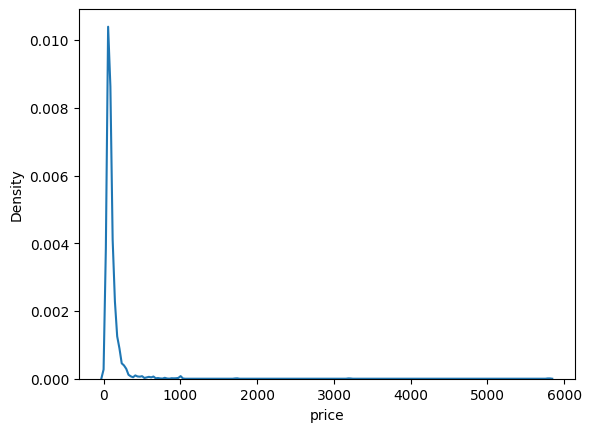

In [10]:
from matplotlib import pyplot as plt
sns.kdeplot(calender_df['price'])

<Axes: ylabel='price'>

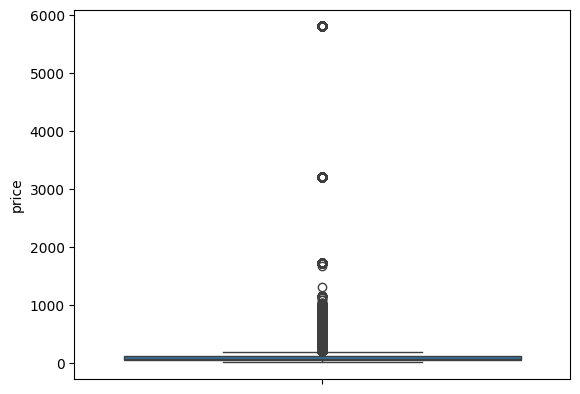

In [13]:
#Boxplot of price columns
sns.boxplot(calender_df['price'])

In [14]:
#Frequency distribution of availablity
calender_df['available'].value_counts()

1    170829
0    148288
Name: available, dtype: int64

In [15]:
calender_df['available'].value_counts() / calender_df.shape[0] *100

1    53.531777
0    46.468223
Name: available, dtype: float64

<Axes: xlabel='available', ylabel='count'>

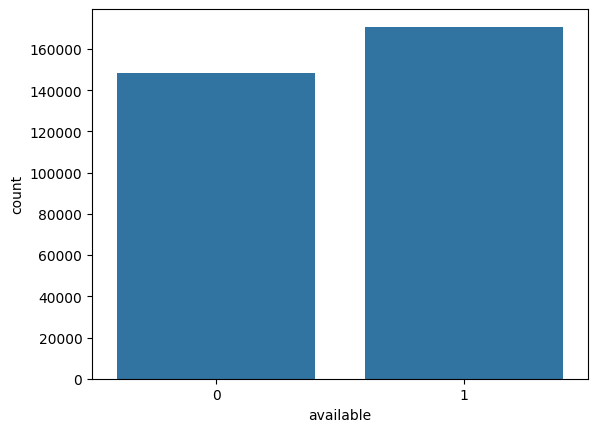

In [16]:
#Countplot for availablity
sns.countplot(x = 'available', data = calender_df)

<Axes: xlabel='price', ylabel='minimum_nights'>

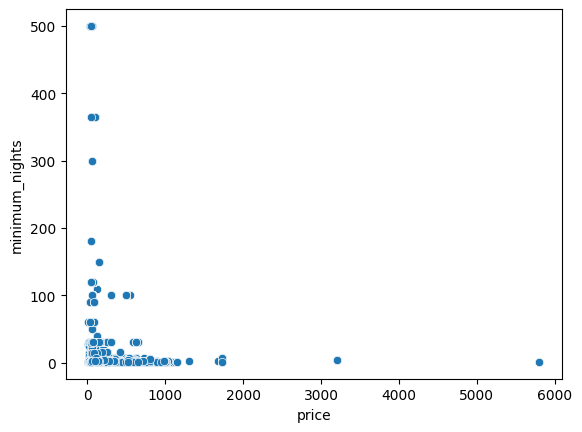

In [17]:
#scatter plot
sns.scatterplot(y = 'minimum_nights', x = 'price', data = calender_df)

<Axes: xlabel='price', ylabel='maximum_nights'>

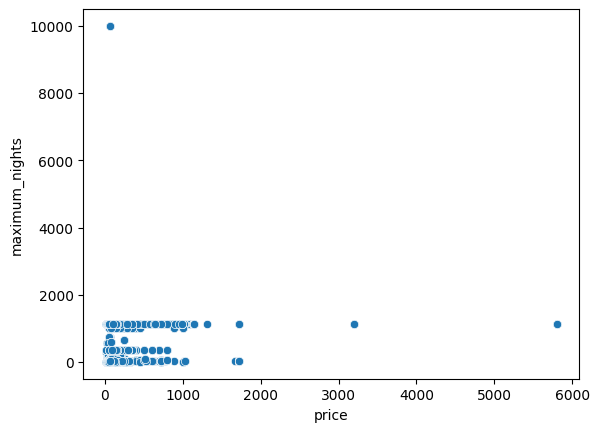

In [18]:
sns.scatterplot(y = 'maximum_nights', x = 'price', data = calender_df)

* we can clearly see that there is outliers present in the price , minimum_nights and maximum_nights.


In [11]:
#outliers removal from the columns :  price , minimum_nights and maximum_nights
import pandas as pd

def remove_outliers(df, column_name):
    # Calculate the first and third quartiles
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return filtered_df


In [17]:
calender_df = remove_outliers(calender_df, 'price')

In [18]:
#Change in shape
calender_data.shape, calender_df.shape

((319192, 8), (282285, 8))

<Axes: ylabel='price'>

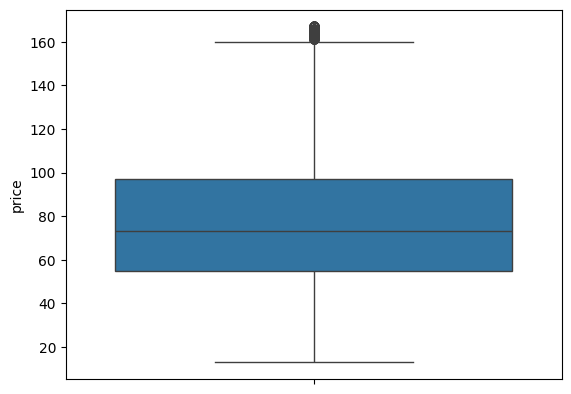

In [21]:
#Boxplot of price columns
sns.boxplot(calender_df['price'])

<Axes: ylabel='minimum_nights'>

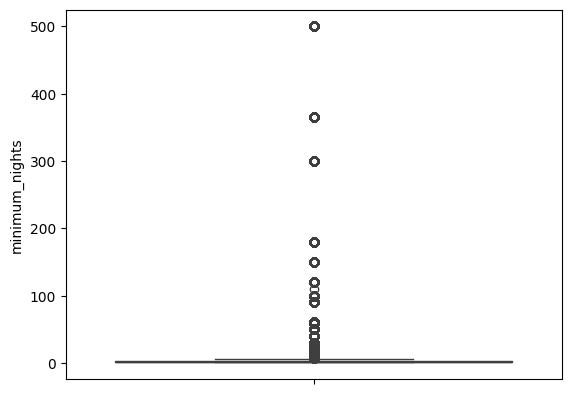

In [22]:
#Boxplot of minimum_nights column
sns.boxplot(calender_df['minimum_nights'])

<Axes: ylabel='maximum_nights'>

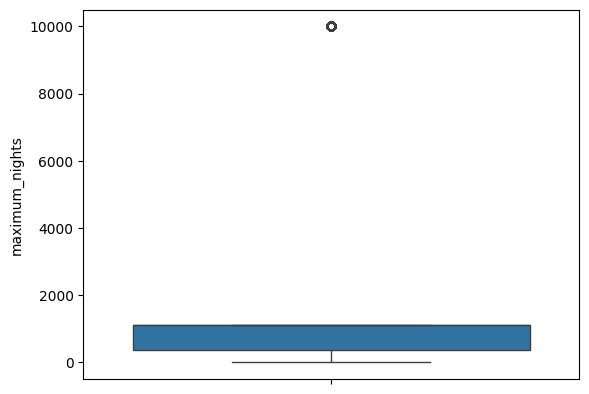

In [24]:
#Boxplot of maximum_nights column
sns.boxplot(calender_df['maximum_nights'])

In [25]:
#removing outliers from the minimum_nights column
calender_df = remove_outliers(calender_df, 'minimum_nights')

In [26]:
#Change in shape
calender_data.shape , calender_df.shape

((319192, 8), (245269, 8))

<Axes: ylabel='minimum_nights'>

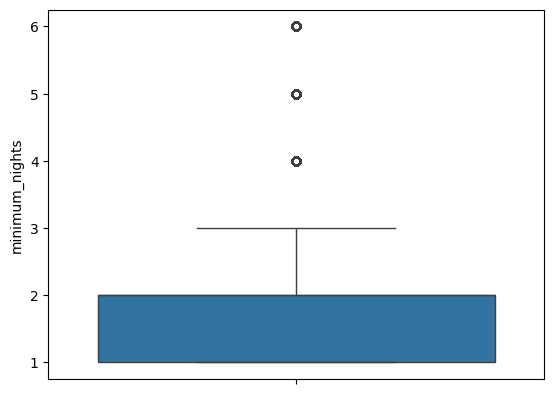

In [28]:
#Boxplot of maximum_nights column
sns.boxplot(calender_df['minimum_nights'])

<Axes: xlabel='price', ylabel='minimum_nights'>

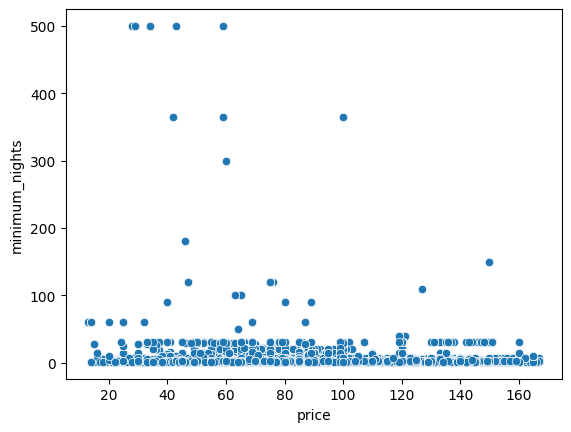

In [19]:
#scatter plot of minimum nights and price column
sns.scatterplot(y = 'minimum_nights', x = 'price', data = calender_df)

<Axes: xlabel='price', ylabel='maximum_nights'>

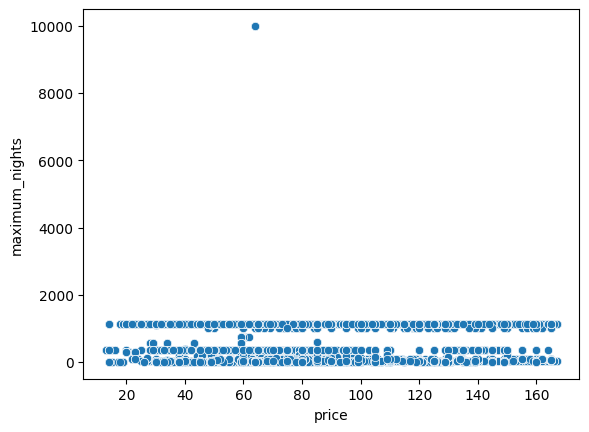

In [20]:
#scatter plot of maximum nights and price column
sns.scatterplot(y = 'maximum_nights', x = 'price', data = calender_df)

In [14]:
#for minimum_nights column
#calender_df2 = remove_outliers(calender_df1,'minimum_nights')

In [23]:
#calender_df1.shape, calender_df2.shape

In [24]:
#for maximum_nights column
#calender_df3= remove_outliers(calender_df2,'maximum_nights')


In [25]:
#calender_df2.shape, calender_df3.shape

In [26]:
# distribution of minimum nights and maximum nights
#sns.histplot( x = 'maximum_nights', data = calender_df3)


* Most of the listings are available to be booked for more than 1000 days

In [27]:
# distribution of minimum_nights
#calender_df3.groupby('minimum_nights').size().plot(kind = 'bar')

* Most of the listings are available for booking at minimum nights of 1 and 2.

<Axes: xlabel='adjusted_price', ylabel='Density'>

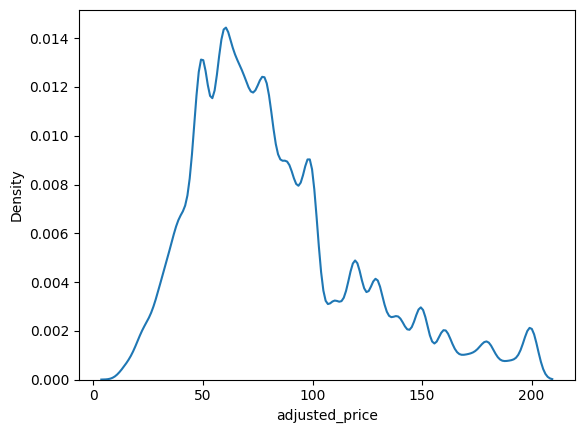

In [28]:
# distribution of price column
sns.kdeplot(calender_df['adjusted_price'])

* The price column is right skewed.

In [29]:
# #Transformation of price column
# calender_df['adjusted_price'] = np.log(calender_df['adjusted_price'])
# from matplotlib import pyplot as plt
# sns.kdeplot(calender_df['adjusted_price'])

#### Host data

In [30]:
host_data.head()

,host_id,host_name,host_since,host_location,host_about
0,234077,Karin,2010-09-14 00:00:00.000000,"Antwerp, Flanders, Belgium",Ever since my childhood I dreamt of having my ...
1,334804,Ann,2011-01-04 00:00:00.000000,"Antwerp, Flemish Region, Belgium","Ciao, \r\nlooking forward to meet you!\r\nI lo..."
2,413052,Valérie,2011-02-27 00:00:00.000000,"Antwerp, Flanders, Belgium",NaN
3,452791,Tatiana,2011-03-20 00:00:00.000000,"Antwerp, Flanders, Belgium",World traveler with a penchant for adrenaline ...
4,462975,Els,2011-03-25 00:00:00.000000,"Edegem, Flanders, Belgium",I studied languages and cultural anthropology ...


In [31]:
host_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   host_id        1111 non-null   int64 
 1   host_name      1111 non-null   object
 2   host_since     1111 non-null   object
 3   host_location  1108 non-null   object
 4   host_about     490 non-null    object
dtypes: int64(1), object(4)
memory usage: 43.5+ KB


In [32]:
#Removing the null values present in the host_location
host_df.dropna(subset = ['host_location'],inplace = True)

In [33]:
host_df.describe(include = 'O')

,host_name,host_since,host_location,host_about
count,1108,1108,1108,490
unique,749,925,149,488
top,Jan,2015-06-03 00:00:00.000000,"Antwerp, Flanders, Belgium","Hello traveller,\n\nWelcome to my profile! My ..."
freq,10,4,676,2


* There are 749 unique hosts.
* Hosts are serving from 149 unique locations.


In [34]:
host_df.groupby('host_location').size().sort_values()

host_location
 Zeeland, Netherlands                     1
Kiryas Joel, New York, United States      1
Kinrooi, Flanders, Belgium                1
Sitges, Catalonia, Spain                  1
Skopje, North Macedonia                   1
                                       ... 
Antwerpen, Vlaams Gewest, Belgium        20
Antwerpen, Vlaanderen, Belgium           25
Belgium                                  27
BE                                      114
Antwerp, Flanders, Belgium              676
Length: 149, dtype: int64

#### Listing data

In [35]:
listing_data.head()

,listing_id,listing_url,name,description,latitude,longitude,property_type,room_type,accomodates,bathrooms_text,bedrooms,beds,amenities,host_id
0,50904,https://www.airbnb.com/rooms/50904,aplace/antwerp: cosy suite - fashion district,Decorated in a vintage style combined with a f...,51.218575,4.398631,Room in boutique hotel,Hotel room,2,1 private bath,1.0,1.0,"[""Kitchen"", ""Smoke alarm"", ""Hair dryer"", ""Keyp...",234077
1,116134,https://www.airbnb.com/rooms/116134,Spacious apartment nearby Mas,Enjoy your stay at our 4 person apartment in t...,51.230510,4.405930,Entire rental unit,Entire home/apt,4,2.5 baths,2.0,2.0,"[""Refrigerator"", ""Elevator"", ""Paid street park...",586942
2,218916,https://www.airbnb.com/rooms/218916,Apartment with terrace in trendy Zurenborg,Do you enjoy authentic places with a lot of ch...,51.206330,4.429420,Entire condominium (condo),Entire home/apt,5,1 bath,1.0,3.0,"[""Paid street parking off premises"", ""Kitchen""...",915664
3,224333,https://www.airbnb.com/rooms/224333,Large stylish room in 1930s house + garden,"Large bedroom in classic 1930s house. Kitchen,...",51.197720,4.458530,Private room in residential home,Private room,2,2 shared baths,1.0,1.0,"[""Fire extinguisher"", ""Backyard"", ""Long term s...",1167377
4,224682,https://www.airbnb.com/rooms/224682,APARTMENT ROSCAM - OLD CENTRE ANTWERP,"<b>The space</b><br />Apartment ""Roscam"" is a ...",51.217220,4.397900,Entire rental unit,Entire home/apt,3,1 bath,1.0,2.0,"[""Refrigerator"", ""Kitchen"", ""Smoke alarm"", ""Sh...",1263933


In [36]:
#Data information
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      1749 non-null   int64  
 1   listing_url     1749 non-null   object 
 2   name            1749 non-null   object 
 3   description     1679 non-null   object 
 4   latitude        1749 non-null   float64
 5   longitude       1749 non-null   float64
 6   property_type   1749 non-null   object 
 7   room_type       1749 non-null   object 
 8   accomodates     1749 non-null   int64  
 9   bathrooms_text  1749 non-null   object 
 10  bedrooms        1621 non-null   float64
 11  beds            1708 non-null   float64
 12  amenities       1749 non-null   object 
 13  host_id         1749 non-null   int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 191.4+ KB


In [37]:
#Data overview
listing_df.describe()

,listing_id,latitude,longitude,accomodates,bedrooms,beds,host_id
count,1.749000e+03,1749.000000,1749.000000,1749.000000,1621.000000,1708.000000,1.749000e+03
mean,3.485506e+07,51.214069,4.413165,3.761578,1.529303,2.220726,1.417765e+08
std,1.523689e+07,0.013740,0.019373,2.771378,1.091453,2.227509,1.286506e+08
min,5.090400e+04,51.160084,4.290770,1.000000,1.000000,1.000000,2.340770e+05
25%,2.337286e+07,51.207870,4.400240,2.000000,1.000000,1.000000,2.875771e+07
50%,3.889829e+07,51.216540,4.409460,3.000000,1.000000,2.000000,1.033633e+08
75%,4.838954e+07,51.220880,4.424660,4.000000,2.000000,3.000000,2.344842e+08
max,5.398332e+07,51.349400,4.483470,16.000000,20.000000,44.000000,4.373093e+08


In [38]:
listing_df.describe(include = 'O')

,listing_url,name,description,property_type,room_type,bathrooms_text,amenities
count,1749,1749,1679,1749,1749,1749,1749
unique,1749,1710,1556,39,4,26,1656
top,https://www.airbnb.com/rooms/50904,Luxury Suites Castel,"Bright and beautiful newly built apartment, ve...",Entire rental unit,Entire home/apt,1 bath,"[""Refrigerator"", ""Kitchen"", ""Smoke alarm"", ""Sh..."
freq,1,5,10,981,1379,825,9


* The number of accomodates vary from the 1 to 16.
* The number of beds are having values of 44 which is an anamoly.
* There are 39 different property_types present in the data.
* We can extract the number of bathrooms and kind of bathroom from bathrooms_text.
* We can use amentities column to extract different amentities available in a particular list.
* We need to impute the values the bedrooms and beds column.


In [39]:
# Frequency distribution of bedrooms
listing_df['bedrooms'].value_counts()

1.0     1047
2.0      428
3.0       91
4.0       31
5.0       11
7.0        5
10.0       2
11.0       1
8.0        1
6.0        1
9.0        1
15.0       1
20.0       1
Name: bedrooms, dtype: int64

<Axes: xlabel='beds'>

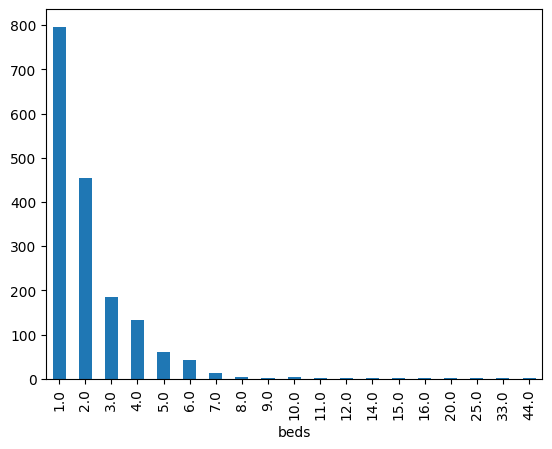

In [40]:
# Frequency distribution of bedrooms
listing_df.groupby('beds').size().plot(kind ='bar')

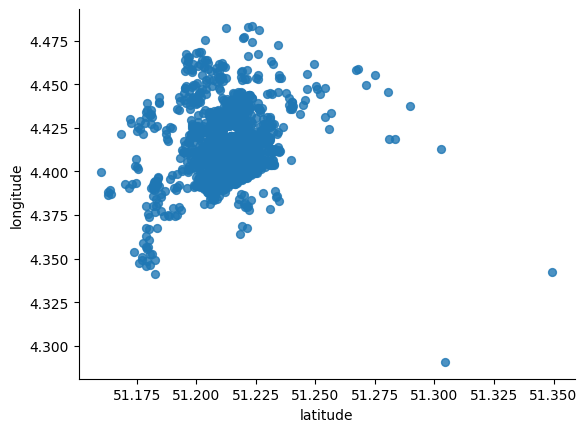

In [41]:
# @title latitude vs longitude

from matplotlib import pyplot as plt
listing_data.plot(kind='scatter', x='latitude', y='longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='latitude', ylabel='longitude'>

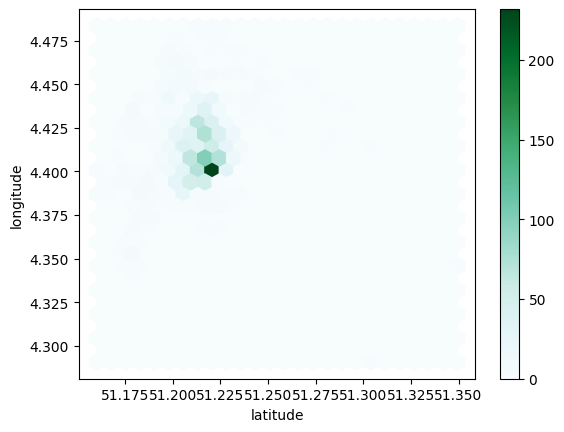

In [42]:
listing_data.plot.hexbin(x='latitude', y='longitude', gridsize=25)

<Axes: xlabel='accomodates'>

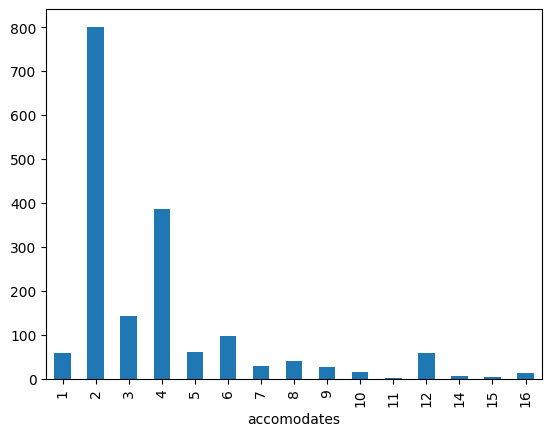

In [43]:
#Frequency distribution of accomodates
listing_df.groupby('accomodates').size().plot(kind ='bar')

<ipython-input-44-34d00ae91796>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(listing_data, x='accomodates', y='room_type', inner='box', palette='Dark2')


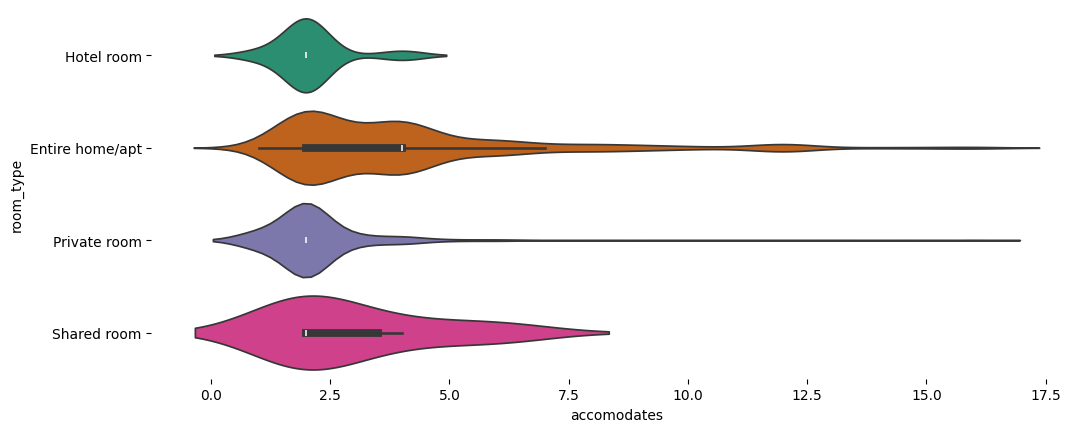

In [44]:
# @title room_type vs accomodates

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(listing_data['room_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(listing_data, x='accomodates', y='room_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [45]:
#Handling null values
mode_value = listing_df['beds'].mode()[0]

# Impute null values with the mode
listing_df['beds'].fillna(mode_value, inplace=True)

# Check if there are any null values left
print(listing_df['beds'].isnull().sum())

0


In [46]:
# Splitting and handling non-numeric values
split_df = listing_df['bathrooms_text'].str.split(' ', n=1, expand=True)
listing_df['no_of_bathroom'] = split_df[0].apply(lambda x: float(x) if x.replace('.', '', 1).isdigit() else None)
listing_df['kind_of_bathroom'] = split_df[1]

# Check the DataFrame after splitting
print(listing_df[['no_of_bathroom', 'kind_of_bathroom']])



      no_of_bathroom kind_of_bathroom
0                1.0     private bath
1                2.5            baths
2                1.0             bath
3                2.0     shared baths
4                1.0             bath
...              ...              ...
1744             1.5            baths
1745             1.0             bath
1746             1.0             bath
1747             7.5            baths
1748             1.5            baths

[1749 rows x 2 columns]


In [47]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        1749 non-null   int64  
 1   listing_url       1749 non-null   object 
 2   name              1749 non-null   object 
 3   description       1679 non-null   object 
 4   latitude          1749 non-null   float64
 5   longitude         1749 non-null   float64
 6   property_type     1749 non-null   object 
 7   room_type         1749 non-null   object 
 8   accomodates       1749 non-null   int64  
 9   bathrooms_text    1749 non-null   object 
 10  bedrooms          1621 non-null   float64
 11  beds              1749 non-null   float64
 12  amenities         1749 non-null   object 
 13  host_id           1749 non-null   int64  
 14  no_of_bathroom    1738 non-null   float64
 15  kind_of_bathroom  1744 non-null   object 
dtypes: float64(5), int64(3), object(8)
memory 

In [48]:
pd.set_option('display.max_columns', None)  # Setting to display all columns

In [49]:
# applying the floor of no of bathroom
listing_df['no_of_bathroom'] =  np.floor(listing_df['no_of_bathroom'])
print(listing_df['no_of_bathroom'])

0       1.0
1       2.0
2       1.0
3       2.0
4       1.0
       ... 
1744    1.0
1745    1.0
1746    1.0
1747    7.0
1748    1.0
Name: no_of_bathroom, Length: 1749, dtype: float64


In [50]:
#data having null rows with no_of_bathroom
listing_df['no_of_bathroom'].isnull().sum()

11

In [51]:
#removing the null values present in the column no_of_bathroom
listing_df.dropna(subset = ['no_of_bathroom'], inplace = True)

In [52]:
#changing the data type of no_of_bathroom
listing_df['no_of_bathroom'].astype(int)

0       1
1       2
2       1
3       2
4       1
       ..
1744    1
1745    1
1746    1
1747    7
1748    1
Name: no_of_bathroom, Length: 1738, dtype: int64

In [53]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1738 entries, 0 to 1748
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        1738 non-null   int64  
 1   listing_url       1738 non-null   object 
 2   name              1738 non-null   object 
 3   description       1668 non-null   object 
 4   latitude          1738 non-null   float64
 5   longitude         1738 non-null   float64
 6   property_type     1738 non-null   object 
 7   room_type         1738 non-null   object 
 8   accomodates       1738 non-null   int64  
 9   bathrooms_text    1738 non-null   object 
 10  bedrooms          1612 non-null   float64
 11  beds              1738 non-null   float64
 12  amenities         1738 non-null   object 
 13  host_id           1738 non-null   int64  
 14  no_of_bathroom    1738 non-null   float64
 15  kind_of_bathroom  1738 non-null   object 
dtypes: float64(5), int64(3), object(8)
memory 

In [54]:
#One hot encoding / Feature engineering
amenity_counts = {}
for amenities in listing_df['amenities']:
    amenities_list = amenities.strip('][').split(', ')
    for amenity in amenities_list:
        amenity = amenity.strip().strip('"\'')  # Removing both single and double quotes
        if amenity not in amenity_counts:
            amenity_counts[amenity] = 1
        else:
            amenity_counts[amenity] += 1

print(amenity_counts)


{'Kitchen': 1580, 'Smoke alarm': 1568, 'Hair dryer': 1330, 'Keypad': 104, 'Carbon monoxide alarm': 805, 'Mini fridge': 214, 'Wifi': 1674, 'Dishes and silverware': 1245, 'Security cameras on property': 95, 'Clothing storage': 226, 'Luggage dropoff allowed': 469, 'Bed linens': 1063, 'Iron': 1026, 'Dedicated workspace': 1181, 'Microwave': 954, 'Molton Brown body soap': 4, 'Essentials': 1639, 'Hot water kettle': 411, 'Long term stays allowed': 1436, 'Portable fans': 162, 'Wine glasses': 467, 'Heating': 1457, 'Paid parking off premises': 377, 'Hot water': 1337, 'Fire extinguisher': 1216, 'Bluetooth sound system': 32, 'Coffee maker': 1096, 'Molton Brown shampoo': 4, 'Safe': 22, 'Hangers': 1431, 'Cable TV': 386, 'TV with standard cable': 365, 'Shower gel': 587, 'Refrigerator': 1128, 'Elevator': 439, 'Paid street parking off premises': 93, 'Shampoo': 1208, 'Outdoor furniture': 190, 'Stove': 843, 'Oven': 864, 'Cooking basics': 1231, 'Clothing storage: dresser': 30, 'wardrobe': 3, 'and closet': 

In [55]:
sorted_amenity_counts = dict(sorted(amenity_counts.items(), key=lambda x: x[1], reverse=True))
sorted_amenity_counts

{'Wifi': 1674,
 'Essentials': 1639,
 'Kitchen': 1580,
 'Smoke alarm': 1568,
 'Heating': 1457,
 'Long term stays allowed': 1436,
 'Hangers': 1431,
 'Hot water': 1337,
 'Hair dryer': 1330,
 'Dishes and silverware': 1245,
 'Cooking basics': 1231,
 'Fire extinguisher': 1216,
 'Shampoo': 1208,
 'Dedicated workspace': 1181,
 'Refrigerator': 1128,
 'Coffee maker': 1096,
 'Bed linens': 1063,
 'Iron': 1026,
 'Microwave': 954,
 'First aid kit': 905,
 'Oven': 864,
 'Stove': 843,
 'Washer': 810,
 'Carbon monoxide alarm': 805,
 'Private entrance': 775,
 'TV': 708,
 'Extra pillows and blankets': 678,
 'Dishwasher': 597,
 'Shower gel': 587,
 'Cleaning products': 519,
 'Dryer': 511,
 'Dining table': 491,
 'Freezer': 488,
 'Luggage dropoff allowed': 469,
 'Wine glasses': 467,
 'Host greets you': 460,
 'Elevator': 439,
 'Body soap': 423,
 'Hot water kettle': 411,
 'Cable TV': 386,
 'Paid parking off premises': 377,
 'TV with standard cable': 365,
 'Room-darkening shades': 348,
 'Lockbox': 345,
 'Laundro

In [56]:
imp_amenities = []
for key, value in sorted_amenity_counts.items():
  if sorted_amenity_counts[key] > 500:
    imp_amenities.append(key)

In [57]:
print(imp_amenities)

['Wifi', 'Essentials', 'Kitchen', 'Smoke alarm', 'Heating', 'Long term stays allowed', 'Hangers', 'Hot water', 'Hair dryer', 'Dishes and silverware', 'Cooking basics', 'Fire extinguisher', 'Shampoo', 'Dedicated workspace', 'Refrigerator', 'Coffee maker', 'Bed linens', 'Iron', 'Microwave', 'First aid kit', 'Oven', 'Stove', 'Washer', 'Carbon monoxide alarm', 'Private entrance', 'TV', 'Extra pillows and blankets', 'Dishwasher', 'Shower gel', 'Cleaning products', 'Dryer']


In [58]:

for amenity in imp_amenities:
    listing_df[amenity] = listing_df['amenities'].apply(lambda x: 1 if amenity in x else 0)

In [59]:

listing_df.head()

,listing_id,listing_url,name,description,latitude,longitude,property_type,room_type,accomodates,bathrooms_text,bedrooms,beds,amenities,host_id,no_of_bathroom,kind_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Dishes and silverware,Cooking basics,Fire extinguisher,Shampoo,Dedicated workspace,Refrigerator,Coffee maker,Bed linens,Iron,Microwave,First aid kit,Oven,Stove,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer
0,50904,https://www.airbnb.com/rooms/50904,aplace/antwerp: cosy suite - fashion district,Decorated in a vintage style combined with a f...,51.218575,4.398631,Room in boutique hotel,Hotel room,2,1 private bath,1.0,1.0,"[""Kitchen"", ""Smoke alarm"", ""Hair dryer"", ""Keyp...",234077,1.0,private bath,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0
1,116134,https://www.airbnb.com/rooms/116134,Spacious apartment nearby Mas,Enjoy your stay at our 4 person apartment in t...,51.230510,4.405930,Entire rental unit,Entire home/apt,4,2.5 baths,2.0,2.0,"[""Refrigerator"", ""Elevator"", ""Paid street park...",586942,2.0,baths,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0
2,218916,https://www.airbnb.com/rooms/218916,Apartment with terrace in trendy Zurenborg,Do you enjoy authentic places with a lot of ch...,51.206330,4.429420,Entire condominium (condo),Entire home/apt,5,1 bath,1.0,3.0,"[""Paid street parking off premises"", ""Kitchen""...",915664,1.0,bath,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,1,1,0
3,224333,https://www.airbnb.com/rooms/224333,Large stylish room in 1930s house + garden,"Large bedroom in classic 1930s house. Kitchen,...",51.197720,4.458530,Private room in residential home,Private room,2,2 shared baths,1.0,1.0,"[""Fire extinguisher"", ""Backyard"", ""Long term s...",1167377,2.0,shared baths,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,224682,https://www.airbnb.com/rooms/224682,APARTMENT ROSCAM - OLD CENTRE ANTWERP,"<b>The space</b><br />Apartment ""Roscam"" is a ...",51.217220,4.397900,Entire rental unit,Entire home/apt,3,1 bath,1.0,2.0,"[""Refrigerator"", ""Kitchen"", ""Smoke alarm"", ""Sh...",1263933,1.0,bath,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0


In [60]:
mode_value = listing_df['bedrooms'].mode()[0]

# Impute null values with the mode
listing_df['bedrooms'].fillna(mode_value, inplace=True)

# Check if there are any null values left
print(listing_df['bedrooms'].isnull().sum())

0


In [61]:
#different property types present in the data
listing_df['property_type'].unique()

array(['Room in boutique hotel', 'Entire rental unit',
       'Entire condominium (condo)', 'Private room in residential home',
       'Private room in townhouse', 'Entire loft',
       'Entire residential home', 'Private room in boat',
       'Private room in bed and breakfast', 'Entire townhouse',
       'Private room in loft', 'Shared room in residential home',
       'Private room in rental unit', 'Entire cottage', 'Private room',
       'Entire villa', 'Yurt', 'Houseboat',
       'Private room in condominium (condo)', 'Tent',
       'Entire serviced apartment', 'Tiny house', 'Entire guest suite',
       'Private room in guest suite', 'Room in hotel',
       'Private room in guesthouse', 'Private room in villa',
       'Entire guesthouse', 'Room in aparthotel',
       'Private room in religious building', 'Shared room in loft',
       'Casa particular', 'Private room in serviced apartment',
       'Shared room in bed and breakfast',
       'Private room in casa particular',
       

In [62]:
listing_df['room_type'].unique()

array(['Hotel room', 'Entire home/apt', 'Private room', 'Shared room'],
      dtype=object)

#### Reviews data

In [63]:
reviews_df.head()

,review_id,listing_id,date,reviewer_id,reviewer_name,comments
0,1,50904,2015-05-06 00:00:00.000000,19482395,Jihae,Karin’s “Aplace” is absolutely beautiful and c...
1,2,50904,2021-10-10 00:00:00.000000,333559,Emilie,"Karin is a wonderful host, she was really help..."
2,3,116134,2012-03-05 00:00:00.000000,928644,Aurélien,"Amazing flat, really close from the MAS Musem,..."
3,4,116134,2012-05-25 00:00:00.000000,231288,Gail,"This is a well equipped, very comfortable apar..."
4,5,116134,2013-09-03 00:00:00.000000,7984251,Marcel,This is a very nice appartement. We really lik...


In [64]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62987 entries, 0 to 62986
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_id      62987 non-null  int64 
 1   listing_id     62987 non-null  int64 
 2   date           62987 non-null  object
 3   reviewer_id    62987 non-null  int64 
 4   reviewer_name  62987 non-null  object
 5   comments       62923 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.9+ MB


There are some null values present in the data.
We can remove the rows having the comments as null.

In [65]:
#removing the null values
reviews_df.dropna(inplace = True)

In [66]:
# data overview
reviews_df.describe()

,review_id,listing_id,reviewer_id
count,62923.000000,6.292300e+04,6.292300e+04
mean,31484.089872,2.276433e+07,1.147765e+08
std,18180.401611,1.417494e+07,1.132173e+08
min,1.000000,5.090400e+04,5.150000e+02
25%,15740.500000,9.913124e+06,2.431438e+07
50%,31478.000000,2.165832e+07,7.214954e+07
75%,47224.500000,3.405420e+07,1.780036e+08
max,62987.000000,5.382519e+07,4.367984e+08


In [67]:
reviews_df.describe(include = 'O')

,date,reviewer_name,comments
count,62923,62923,62923
unique,2941,13592,61443
top,2021-11-14 00:00:00.000000,David,.
freq,232,319,130


* There are 130 comments as '.' which makes no sense.

In [68]:
#occurence of different comments
reviews_df['comments'].value_counts()

.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               130
Top                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

* There are '.' and '-' comments can be deleted as they do not make any sense.

In [69]:
#removing the rows with comments as '.' and '-'
reviews_df = reviews_df[(reviews_df['comments'] != '.') & (reviews_df['comments'] != '-')]


In [70]:
#Change in shape
reviews_df.shape

(62755, 6)

In [71]:
no_of_reviews = reviews_df.groupby("listing_id").size().reset_index(name='no_of_reviews_count')

In [72]:
no_of_reviews.shape

(1525, 2)

#### Merging dataframes

In [73]:
merge_df1 = pd.merge(calender_df,listing_df, on ="listing_id", how = "inner")
merge_df2 = pd.merge(merge_df1, host_df, on ="host_id", how = "inner")
merged_df = pd.merge(merge_df2, no_of_reviews, on ="listing_id", how = "inner")

In [74]:
merged_df.shape

(258240, 59)

In [75]:
merged_df.head()

,calender_id,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,listing_url,name,description,latitude,longitude,property_type,room_type,accomodates,bathrooms_text,bedrooms,beds,amenities,host_id,no_of_bathroom,kind_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Dishes and silverware,Cooking basics,Fire extinguisher,Shampoo,Dedicated workspace,Refrigerator,Coffee maker,Bed linens,Iron,Microwave,First aid kit,Oven,Stove,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer,host_name,host_since,host_location,host_about,no_of_reviews_count
0,1,40334325,2022-08-03 00:00:00.000000,0,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23 00:00:00.000000,BE,NaN,1
1,2109,40334325,2022-02-14 00:00:00.000000,1,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23 00:00:00.000000,BE,NaN,1
2,3617,40334325,2022-04-26 00:00:00.000000,0,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23 00:00:00.000000,BE,NaN,1
3,5560,40334325,2022-04-08 00:00:00.000000,0,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23 00:00:00.000000,BE,NaN,1
4,8188,40334325,2022-04-11 00:00:00.000000,0,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23 00:00:00.000000,BE,NaN,1


In [76]:
#converting the date column as date time
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date
merged_df['host_since'] = pd.to_datetime(merged_df['host_since']).dt.date

In [77]:
merged_df.head()

,calender_id,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,listing_url,name,description,latitude,longitude,property_type,room_type,accomodates,bathrooms_text,bedrooms,beds,amenities,host_id,no_of_bathroom,kind_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Dishes and silverware,Cooking basics,Fire extinguisher,Shampoo,Dedicated workspace,Refrigerator,Coffee maker,Bed linens,Iron,Microwave,First aid kit,Oven,Stove,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer,host_name,host_since,host_location,host_about,no_of_reviews_count
0,1,40334325,2022-08-03,0,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23,BE,NaN,1
1,2109,40334325,2022-02-14,1,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23,BE,NaN,1
2,3617,40334325,2022-04-26,0,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23,BE,NaN,1
3,5560,40334325,2022-04-08,0,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23,BE,NaN,1
4,8188,40334325,2022-04-11,0,56.0,56.0,3,5,https://www.airbnb.com/rooms/40334325,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1 bath,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,Xander,2019-11-23,BE,NaN,1


* We can remove some columns which are not adding much like: calender_id, listing_url, bathrooms_text, host_name and host_about.

In [78]:
merged_df.drop(columns=['calender_id','listing_url', 'bathrooms_text', 'host_name','host_about'], inplace=True)

In [79]:
merged_df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,name,description,latitude,longitude,property_type,room_type,accomodates,bedrooms,beds,amenities,host_id,no_of_bathroom,kind_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Dishes and silverware,Cooking basics,Fire extinguisher,Shampoo,Dedicated workspace,Refrigerator,Coffee maker,Bed linens,Iron,Microwave,First aid kit,Oven,Stove,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer,host_since,host_location,no_of_reviews_count
0,40334325,2022-08-03,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.209890,4.422980,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
1,40334325,2022-02-14,1,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.209890,4.422980,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
2,40334325,2022-04-26,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.209890,4.422980,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
3,40334325,2022-04-08,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.209890,4.422980,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
4,40334325,2022-04-11,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.209890,4.422980,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258235,35061198,2022-05-04,0,200.0,200.0,2,1125,Unieke woning in het historisch stadscentrum,Karaktervolle stadswoning in oud Antwerpen. De...,51.223904,4.399599,Entire residential home,Entire home/apt,12,2.0,7.0,"[""Refrigerator"", ""Kitchen"", ""Smoke alarm"", ""Sh...",162124474,1.0,baths,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,2017-12-10,"Zwijndrecht, Vlaanderen, Belgium",66
258236,35061198,2022-01-16,1,200.0,200.0,2,1125,Unieke woning in het historisch stadscentrum,Karaktervolle stadswoning in oud Antwerpen. De...,51.223904,4.399599,Entire residential home,Entire home/apt,12,2.0,7.0,"[""Refrigerator"", ""Kitchen"", ""Smoke alarm"", ""Sh...",162124474,1.0,baths,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,2017-12-10,"Zwijndrecht, Vlaanderen, Belgium",66
258237,35061198,2022-01-09,1,200.0,200.0,2,1125,Unieke woning in het historisch stadscentrum,Karaktervolle stadswoning in oud Antwerpen. De...,51.223904,4.399599,Entire residential home,Entire home/apt,12,2.0,7.0,"[""Refrigerator"", ""Kitchen"", ""Smoke alarm"", ""Sh...",162124474,1.0,baths,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,2017-12-10,"Zwijndrecht, Vlaanderen, Belgium",66
258238,813969,2022-01-13,0,199.0,199.0,1,1125,150 m² loft (terrace & river view),This spacious and luxurious loft is located on...,51.213470,4.391250,Entire rental unit,Entire home/apt,6,2.0,3.0,"[""Refrigerator"", ""Kitchen"", 

In [80]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258240 entries, 0 to 258239
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   listing_id                  258240 non-null  int64  
 1   date                        258240 non-null  object 
 2   available                   258240 non-null  int64  
 3   price                       258240 non-null  float64
 4   adjusted_price              258240 non-null  float64
 5   minimum_nights              258240 non-null  int64  
 6   maximum_nights              258240 non-null  int64  
 7   name                        258240 non-null  object 
 8   description                 249402 non-null  object 
 9   latitude                    258240 non-null  float64
 10  longitude                   258240 non-null  float64
 11  property_type               258240 non-null  object 
 12  room_type                   258240 non-null  object 
 13  accomodates   

In [81]:
#Removing this date column
merged_df.drop(columns= ['date'] , inplace = True)

In [82]:
# Now we can go ahead apply ML algorithms

In [83]:
merged_df.head()

,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights,name,description,latitude,longitude,property_type,room_type,accomodates,bedrooms,beds,amenities,host_id,no_of_bathroom,kind_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Dishes and silverware,Cooking basics,Fire extinguisher,Shampoo,Dedicated workspace,Refrigerator,Coffee maker,Bed linens,Iron,Microwave,First aid kit,Oven,Stove,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer,host_since,host_location,no_of_reviews_count
0,40334325,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
1,40334325,1,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
2,40334325,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
3,40334325,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1
4,40334325,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1


#### EDA on the Merged data


In [84]:
merged_df.describe()

,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights,latitude,longitude,accomodates,bedrooms,beds,host_id,no_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Dishes and silverware,Cooking basics,Fire extinguisher,Shampoo,Dedicated workspace,Refrigerator,Coffee maker,Bed linens,Iron,Microwave,First aid kit,Oven,Stove,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer,no_of_reviews_count
count,2.582400e+05,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,2.582400e+05,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000,258240.000000
mean,3.328132e+07,0.525883,82.124985,81.947266,3.951305,816.311811,51.214080,4.413156,3.582760,1.367182,2.008264,1.326267e+08,1.069753,0.971236,0.962322,0.911997,0.905297,0.871437,0.813681,0.847506,0.818533,0.791059,0.775194,0.740935,0.703357,0.721701,0.735862,0.711338,0.686075,0.654519,0.592182,0.587879,0.532598,0.543990,0.541264,0.455313,0.479074,0.446809,0.660626,0.423192,0.360254,0.359967,0.309483,0.287457,42.176386
std,1.515799e+07,0.499331,38.038435,37.759858,11.178114,525.373138,0.013237,0.019234,2.581303,0.706677,1.501740,1.231935e+08,0.300045,0.167143,0.190417,0.283300,0.292804,0.334716,0.389365,0.359500,0.385405,0.406553,0.417456,0.438122,0.456779,0.448162,0.440874,0.453141,0.464087,0.475526,0.491430,0.492218,0.498937,0.498062,0.498295,0.498000,0.499563,0.497164,0.473498,0.494066,0.480075,0.479991,0.462282,0.452578,65.915029
min,5.090400e+04,0.000000,14.000000,14.000000,1.000000,1.000000,51.162880,4.290770,1.000000,1.000000,1.000000,2.340770e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.138169e+07,0.000000,55.000000,55.000000,1.000000,365.000000,51.208230,4.400440,2.000000,1.000000,1.000000,2.620474e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,3.652099e+07,1.000000,75.000000,75.000000,2.000000,1125.000000,51.216780,4.409460,2.000000,1.000000,2.000000,9.006749e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
75%,4.609814e+07,1.000000,100.000000,100.000000,2.000000,1125.000000,51.220720,4.424800,4.000000,2.000000,2.000000,2.207285e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,47.000000
max,5.382519e+07,1.000000,240.000000,200.000000,300.000000,9999.000000,51.304340,4.483470,16.000000,11.000000,20.000000,4.359994e+08,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1

<Axes: xlabel='room_type', ylabel='adjusted_price'>

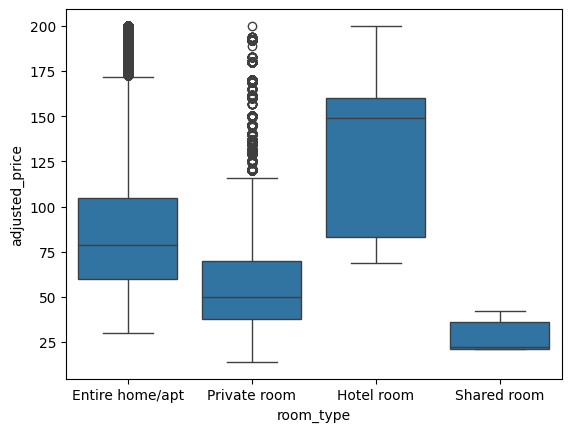

In [85]:
#Distribution of price column for different room types
sns.boxplot(x = 'room_type', y = 'adjusted_price', data = merged_df)

* Private room is varying from low pricing to high pricing.
* Shared room is have low price.
* Hotel room are generally have higher prices than other room types.

In [86]:
# from geopy.geocoders import Nominatim
# import pandas as pd



# # Initialize geolocator
# geolocator = Nominatim(user_agent="Airbnb_Data")

# # Function to reverse geocode coordinates and get address
# def get_address(row):
#     location = geolocator.reverse((row['latitude'], row['longitude']))
#     return location.address

# # Apply the function to each row to get the address
# df['address'] = df.apply(get_address, axis=1)


#

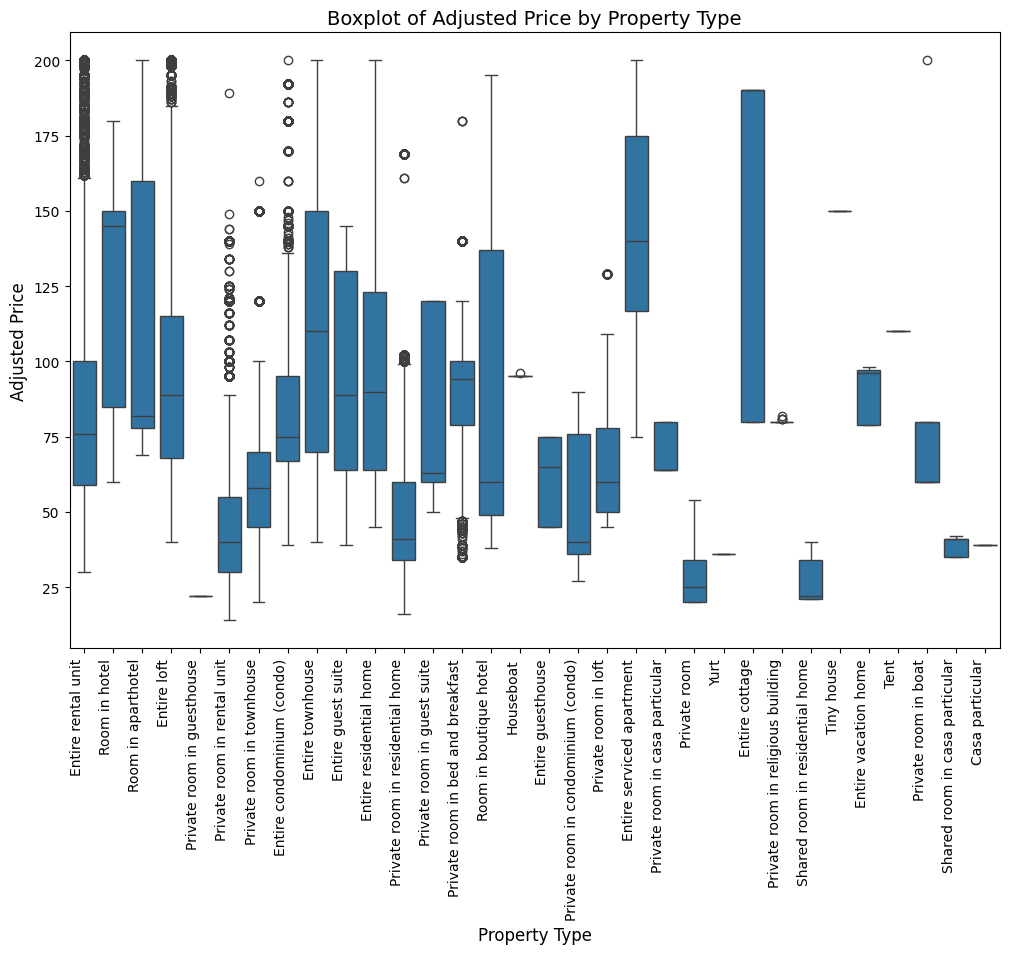

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the boxplot
sns.boxplot(x='property_type', y='adjusted_price', data=merged_df)

# Set labels and title
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Adjusted Price', fontsize=12)
plt.title('Boxplot of Adjusted Price by Property Type', fontsize=14)

# Rotate x-axis labels for better alignment
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()


* There are different price distribution for different property types. So we can use label encoding for it.

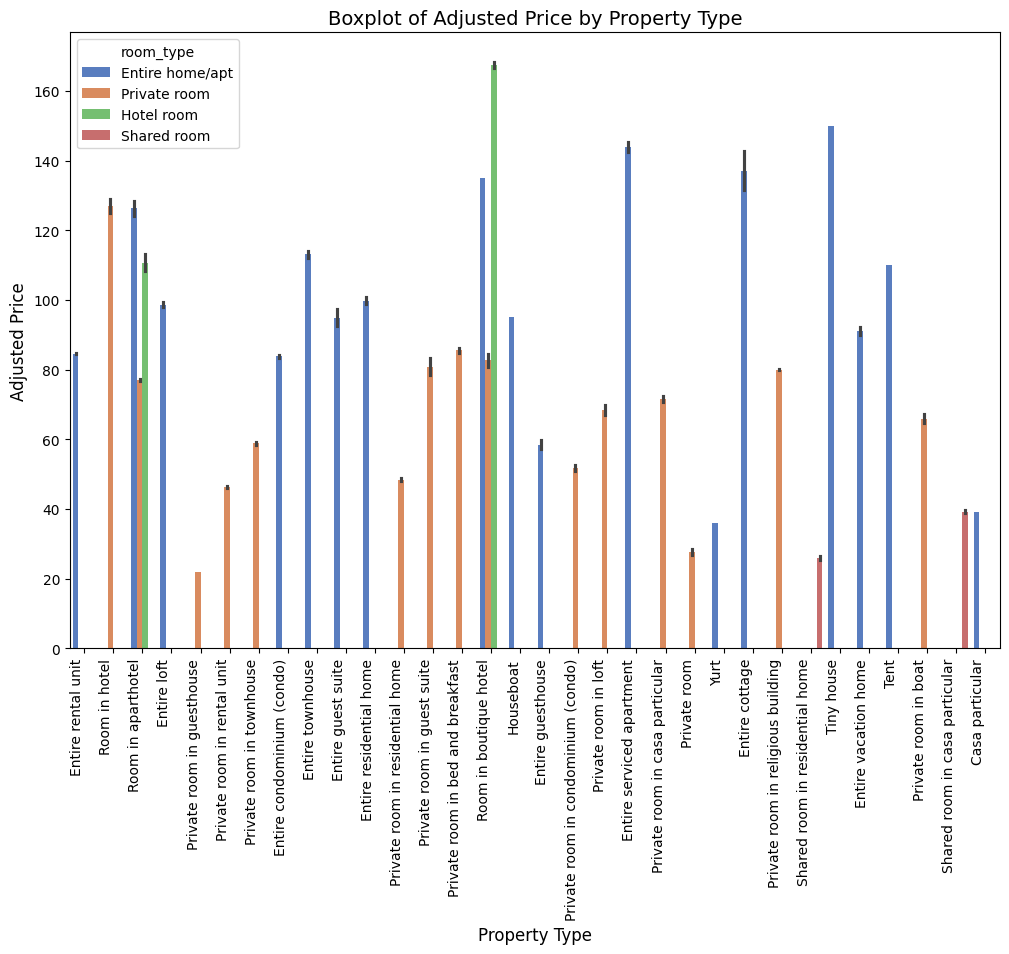

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the boxplot
sns.barplot(x='property_type', y='adjusted_price',hue = 'room_type', data=merged_df, palette='muted')

# Set labels and title
plt.xlabel('Property Type', fontsize=12)
plt.ylabel('Adjusted Price', fontsize=12)
plt.title('Boxplot of Adjusted Price by Property Type', fontsize=14)

# Rotate x-axis labels for better alignment
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()


* Most of the property types are based in the room types. So this property type is not adding much in analysing price of property. We can remove this column further.

<ipython-input-89-9c696b655794>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = merged_df.corr()


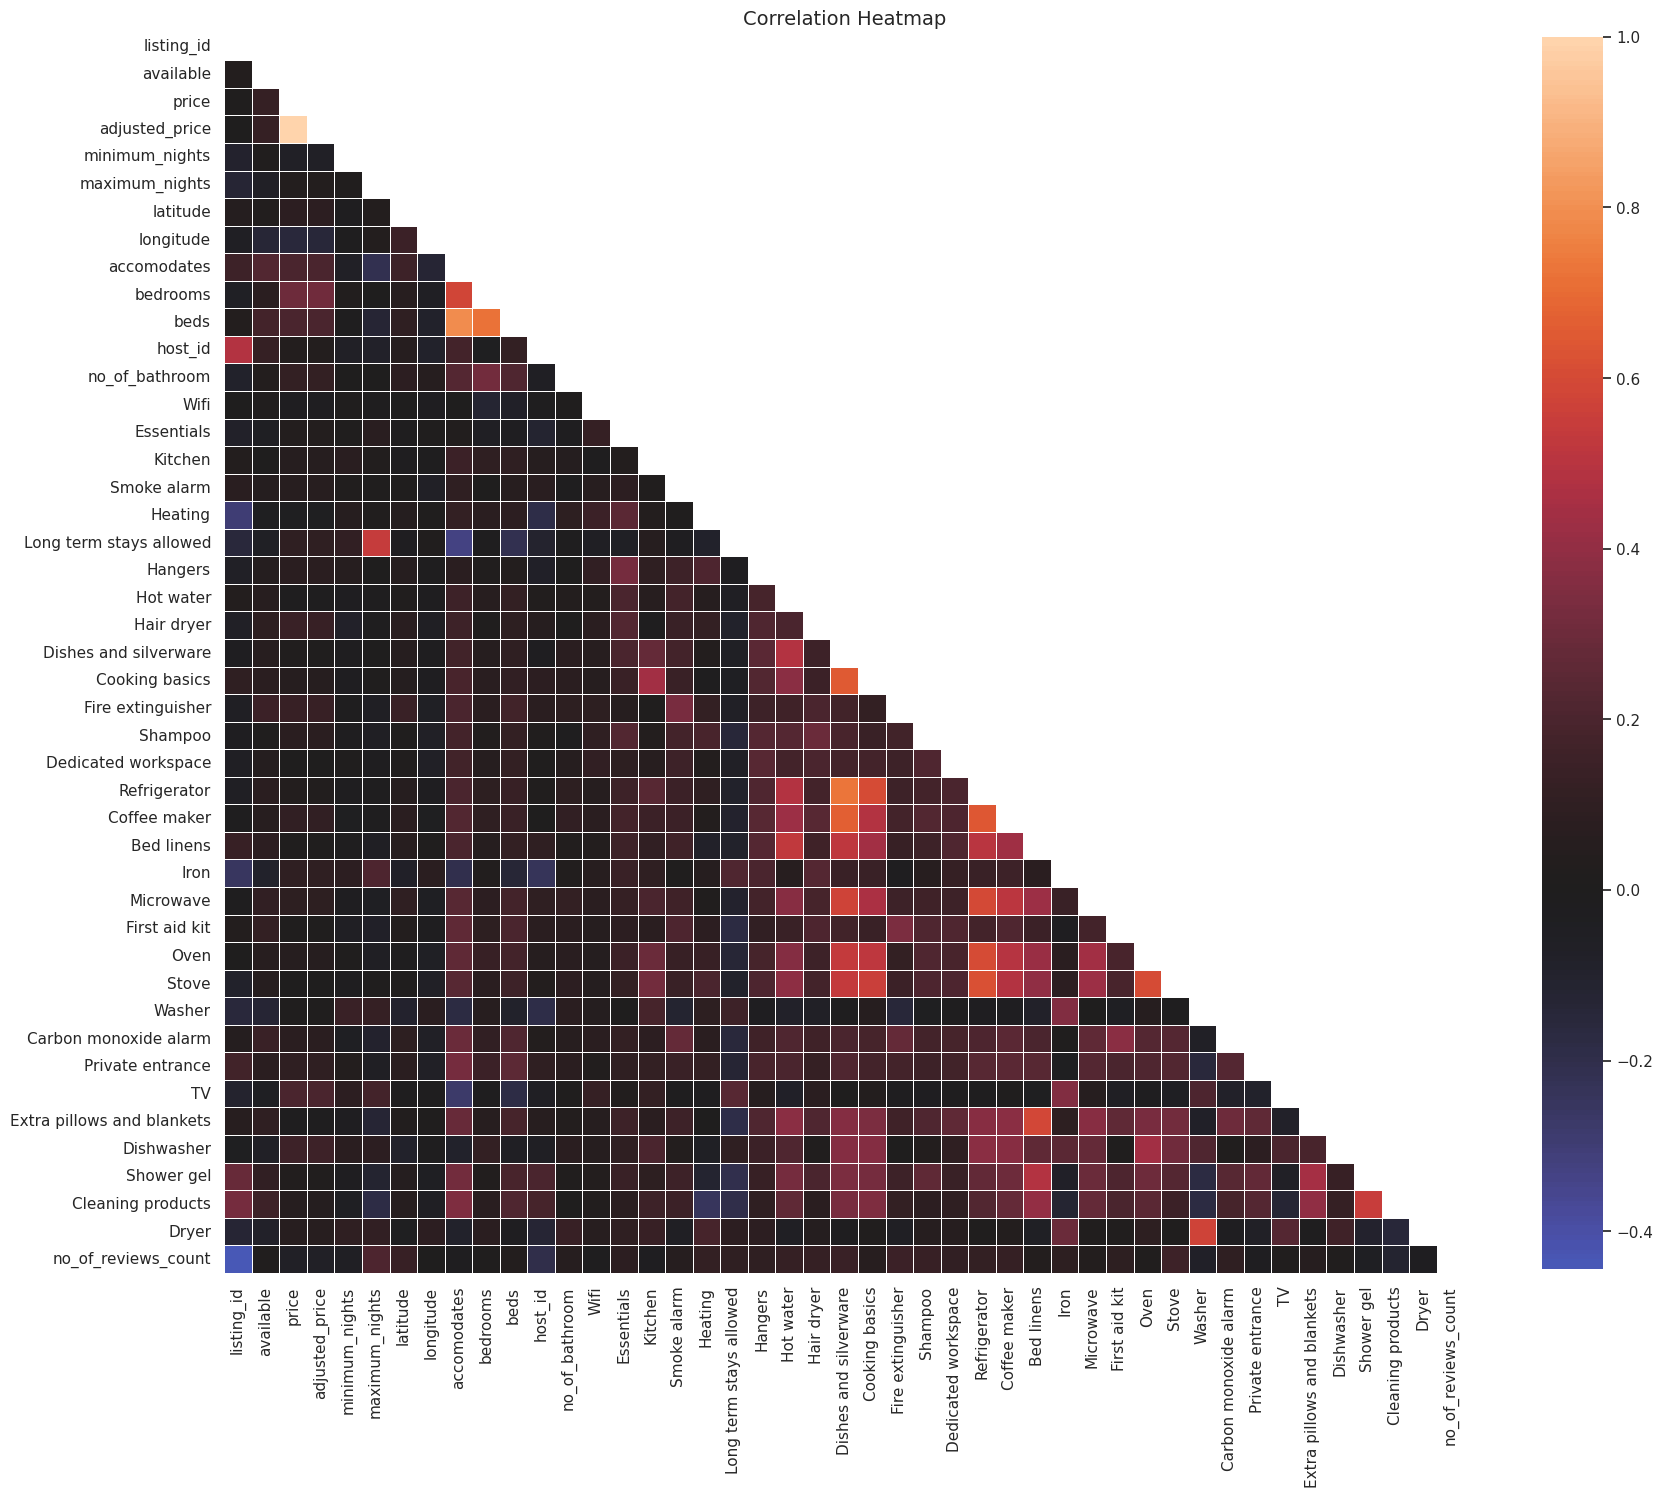

In [89]:
#Correlation
# Correlation plot for our Dataset.
sns.set_theme(style="white")

# Compute the correlation matrix
corr = merged_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,fmt=".2f", vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink":0.8})
plt.title('Correlation Heatmap', fontsize = 14)
plt.show()

* There are some columns having high correlation among themselves, which is sign of multicollinearity. We can use feature engineering to overcome this.
* Oven, Stove, Microwave is having correlation with Dishes and Silver ware, cooking basics and Refrigerator.
* Extra pillow and blankets have correlation with Bed Linens
* Dryer is correlated with Washer.
* Refridgerator and coffee maker is correlated with Dishes and Silver ware, Cooking basics
* Bedrooms , beds and accomodates are correlated with each other.
* Long term stays allowed is correlated with maximum nights.

In [90]:
# I want to create a variable cooking_basics if value in oven is 1 or stove is 1
merged_df['kitchen_esssentials'] = np.where((merged_df['Dishes and silverware'] == 1) | (merged_df['Refrigerator'] == 1) | (merged_df['Oven'] == 1)|
                                   (merged_df['Cooking basics'] == 1)  | (merged_df['Stove'] == 1) | (merged_df['Microwave'] == 1) | (merged_df['Coffee maker'] == 1), 1, 0)


In [91]:
# Now we can drop these columns
merged_df.drop(columns=['Dishes and silverware','Refrigerator', 'Oven', 'Cooking basics','Stove','Microwave'], inplace=True)

In [92]:
# we can drop bedrooms or beds or accomodate any two variable.
merged_df.drop(columns = ['accomodates','bedrooms'], inplace = True)

In [93]:
merged_df.head()

,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights,name,description,latitude,longitude,property_type,room_type,beds,amenities,host_id,no_of_bathroom,kind_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Fire extinguisher,Shampoo,Dedicated workspace,Coffee maker,Bed linens,Iron,First aid kit,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer,host_since,host_location,no_of_reviews_count,kitchen_esssentials
0,40334325,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1
1,40334325,1,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1
2,40334325,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1
3,40334325,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1
4,40334325,0,56.0,56.0,3,5,Luxurious flat in central location,Luxurious flat in Antwerp close to various pub...,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,"[""Hot water"", ""Refrigerator"", ""Private entranc...",311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1


In [94]:
amenities_list = amenities.strip('][').split(', ')
amenity = amenity.strip().strip('"\'')

In [95]:
merged_df['amenities'][0]

'["Hot water", "Refrigerator", "Private entrance", "Elevator", "Kitchen", "Smoke alarm", "Shampoo", "Coffee maker", "Free street parking", "Cooking basics", "Hangers", "Dedicated workspace", "Microwave", "Wifi", "TV", "Heating", "Dishes and silverware", "Essentials"]'

In [96]:
import ast

# Convert the string representation of the list to an actual list
amenities_list = ast.literal_eval(merged_df['amenities'][0])

# Find the number of amenities in the list
num_amenities = len(amenities_list)

# Print the number of amenities
print("Number of amenities:", num_amenities)


Number of amenities: 18


In [97]:
#finding the number of amenities in the amenities column
merged_df['amenities_cleaned'] = merged_df['amenities'].str.strip("[]").str.replace("'", "")
merged_df['amenities_list'] = merged_df['amenities_cleaned'].str.split(", ")

# Find the number of amenities in each list
merged_df['num_amenities'] = merged_df['amenities_list'].apply(len)

# Drop the intermediate columns if needed
merged_df.drop(columns=['amenities_cleaned', 'amenities_list'], inplace=True)


In [98]:
merged_df.drop(columns = ['amenities'], inplace = True)


In [99]:
#These columns do not add anything
merged_df.drop(columns = ['name','description'], inplace = True)

In [100]:
merged_df.head()

,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights,latitude,longitude,property_type,room_type,beds,host_id,no_of_bathroom,kind_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Fire extinguisher,Shampoo,Dedicated workspace,Coffee maker,Bed linens,Iron,First aid kit,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer,host_since,host_location,no_of_reviews_count,kitchen_esssentials,num_amenities
0,40334325,0,56.0,56.0,3,5,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1,18
1,40334325,1,56.0,56.0,3,5,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1,18
2,40334325,0,56.0,56.0,3,5,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1,18
3,40334325,0,56.0,56.0,3,5,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1,18
4,40334325,0,56.0,56.0,3,5,51.20989,4.42298,Entire rental unit,Entire home/apt,2.0,311556587,1.0,bath,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2019-11-23,BE,1,1,18


In [105]:
max(merged_df['host_since']), min(merged_df['host_since'])

(datetime.date(2021, 12, 14), datetime.date(2010, 9, 14))

In [108]:
current_date = pd.Timestamp(2022,1,1)
merged_df['host_since'] = pd.to_datetime(merged_df['host_since'])
merged_df['since_yrs'] = current_date.year - merged_df['host_since'].dt.year

In [119]:
merged_df.head()

,listing_id,available,price,adjusted_price,minimum_nights,maximum_nights,latitude,longitude,beds,no_of_bathroom,Wifi,Essentials,Kitchen,Smoke alarm,Heating,Long term stays allowed,Hangers,Hot water,Hair dryer,Fire extinguisher,Shampoo,Dedicated workspace,Coffee maker,Bed linens,Iron,First aid kit,Washer,Carbon monoxide alarm,Private entrance,TV,Extra pillows and blankets,Dishwasher,Shower gel,Cleaning products,Dryer,no_of_reviews_count,kitchen_esssentials,num_amenities,since_yrs,property_type_encoded,room_type_encoded,bathroom_encoded
0,40334325,0,56.0,56.0,3,5,51.20989,4.42298,2.0,1.0,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,18,3,6,0,0
1,40334325,1,56.0,56.0,3,5,51.20989,4.42298,2.0,1.0,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,18,3,6,0,0
2,40334325,0,56.0,56.0,3,5,51.20989,4.42298,2.0,1.0,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,18,3,6,0,0
3,40334325,0,56.0,56.0,3,5,51.20989,4.42298,2.0,1.0,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,18,3,6,0,0
4,40334325,0,56.0,56.0,3,5,51.20989,4.42298,2.0,1.0,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,18,3,6,0,0


In [110]:
# we can remove the host_since and host_id columns
merged_df.drop(columns = ['host_id','host_since'], inplace = True)

In [112]:
# we can also drop host_location as we have the longitude and latitude for a listing
merged_df.drop(columns = ['host_location'], inplace = True)

In [115]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'property_type' column
merged_df['property_type_encoded'] = label_encoder.fit_transform(merged_df['property_type'])
merged_df['room_type_encoded'] = label_encoder.fit_transform(merged_df['room_type'])
merged_df['bathroom_encoded'] = label_encoder.fit_transform(merged_df['kind_of_bathroom'])


In [118]:
# We can drop these columns
merged_df.drop(columns = ['property_type', 'room_type', 'kind_of_bathroom'], inplace = True)

KeyError: "['property_type', 'room_type', 'kind_of_bathroom'] not found in axis"

In [101]:
#numerical and categorical columns
numerical_cols = ['available','price','minimum_nights','maximum_nights','latitude','longitude','beds',
                  'no_of_bathroom','no_of_reviews_count','kitchen_essentials','num_amenities']
categorical_cols = ['property_type', 'room_type', 'kind_of_bathroom','host_location']


In [121]:
# Train Test Spitting
scaler = MinMaxScaler()
X = merged_df[[col for col in merged_df.columns if col not in ['price','adjusted_price']]]
y = merged_df['price']

X_scale = scaler.fit_transform(X)
y_scale = scaler.fit_transform(y.values.reshape([-1,1])).flatten()

X_train,X_test,y_train,y_test = train_test_split(X_scale,y_scale,test_size = 0.3, random_state = 0)

#### Modelling

In [136]:
def models():
  '''
  This Function returns a dictionary of Regression Algorithms
  '''
  models = dict()
  models['Linear Regression'] = LinearRegression()
  models['knn'] = KNeighborsRegressor()
  models['Decision Tree'] = DecisionTreeRegressor()
  models['SVM'] = SVR()
  models['XGBoost'] = XGBRegressor()
  models['Extra Trees Regressor'] = ExtraTreesRegressor()
  models['Random Forest'] = RandomForestRegressor()
  models['Bagging Regressor'] = BaggingRegressor(base_estimator=KNeighborsRegressor())
  return models

In [138]:
def model_predictions(models,X_train,X_test,y_train):
    '''
    This function is used for training and testing our list of models,
    which is used for returning training and testing predictions those in turn used for evaluation.
    '''
    names=[]
    training_preds = []
    test_preds = []

    for name, model in models.items():                               # Looping over our list of models
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train).tolist()
        training_preds.append(train_pred)
        names.append(name)

        test_pred = model.predict(X_test).tolist()
        test_preds.append(test_pred)

    training_pred_dict = dict(zip(names, training_preds))            # Zipping our models and their
                                                                     # corresponding training predictions into a dictionary.

    train_pred_df = pd.DataFrame.from_dict(training_pred_dict)       # We're converting the above dictionary to a DataFrame.


    test_pred_dict = dict(zip(names, test_preds))                    # Zipping our models and their
                                                                     # corresponding test predictions into a dictionary.

    test_pred_df = pd.DataFrame.from_dict(test_pred_dict)            # We're converting the above dictionary to a DataFrame.

    return train_pred_df,test_pred_df

In [139]:
def evaluation_function(y_train, y_test, train_pred_df, test_pred_df, metric_name):
    '''
    This function is used to compute the Evaluation Metrics for traing and test predictions of our list of models
    '''
    models = train_pred_df.columns.tolist()

    metrics_train = []
    metrics_test = []
    for model in models:
        if metric_name == 'MSE': # Mean Squarred Error
            metric_train = mean_squared_error(y_train, train_pred_df[model])
            metric_test = mean_squared_error(y_test, test_pred_df[model])
        elif metric_name == 'RMSE': # Root Mean Squarred Error
            metric_train = mean_squared_error(y_train, train_pred_df[model], squared=False)
            metric_test = mean_squared_error(y_test, test_pred_df[model],squared=False)
        elif metric_name == 'RMSLE': # Root Mean Squarred Logerithmic Error
            metric_train = metrics.mean_squared_log_error(y_train, train_pred_df[model], squared=False)
            metric_test = metrics.mean_squared_log_error(y_test, test_pred_df[model],squared=False)
        elif metric_name == 'r2_score': # R-squarred Score
            metric_train = r2_score(y_train, train_pred_df[model])
            metric_test = r2_score(y_test, test_pred_df[model])
        metrics_train.append(metric_train)
        metrics_test.append(metric_test)

    metrics_train_dict = dict(zip(models, metrics_train))  # Zipping our models and their corresponding
                                                           # Evaluation results of training predictions into a dictionary.

    metrics_test_dict = dict(zip(models,metrics_test))  # Zipping our models and their corresponding
                                                        # Evaluation results of test predictions into a dictionary.

    metrics_dict={'train':metrics_train_dict,
                 'test':metrics_test_dict}
    metrics_df = pd.DataFrame(metrics_dict)    # Converting our metric dictionaries into a DataFrame.
    metrics_df = metrics_df.transpose()        # Transposing the above DataFrame for our convenience
    metrics_df['Evaluation'] = metric_name
    first_col = metrics_df.pop('Evaluation')
    metrics_df.insert(0, 'Evaluation', first_col)
    return metrics_df

In [140]:
# Capturing train and test predictions in a DataFrame.
train_pred_df, test_pred_df = model_predictions(models(),X_train,X_test,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [141]:
# Displaying Evaluation results(r2_scores) for all the models
evaluation_function(y_train, y_test, train_pred_df, test_pred_df, 'r2_score')

,Evaluation,Linear Regression,knn,Decision Tree,SVM,XGBoost,Extra Trees Regressor,Random Forest,Bagging Regressor
train,r2_score,0.292807,0.865282,0.887389,0.719178,0.881699,0.887389,0.887335,0.884955
test,r2_score,0.294729,0.864550,0.886665,0.724393,0.883209,0.886686,0.886773,0.884666


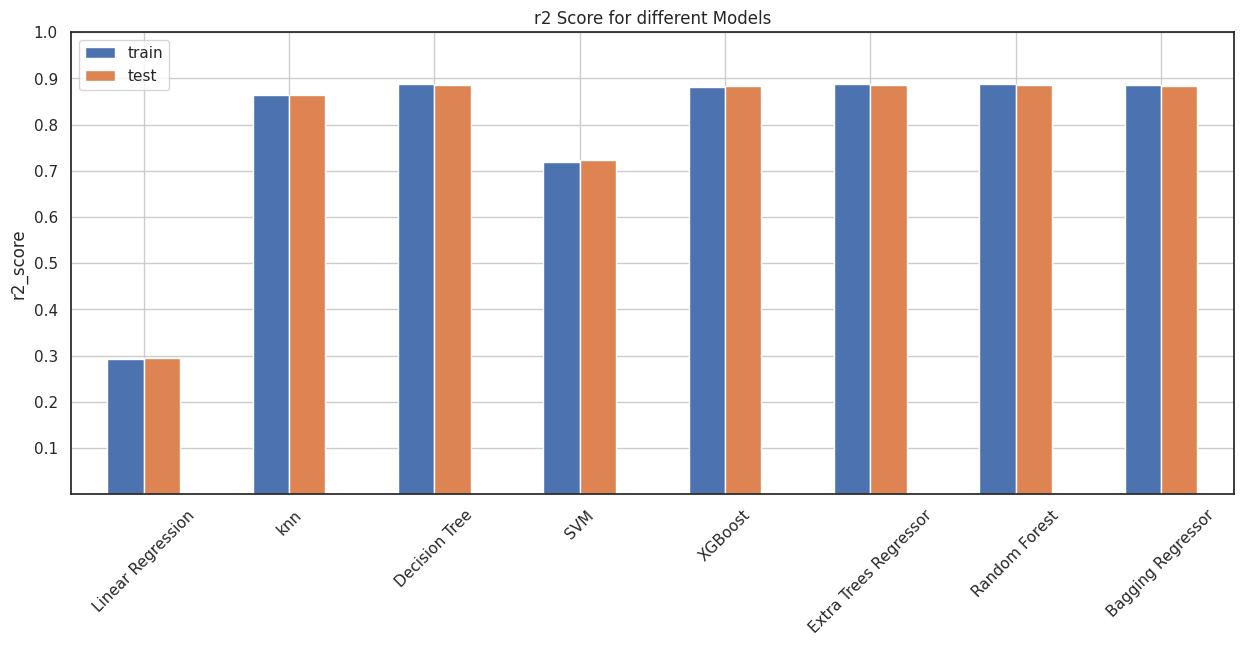

In [142]:
r2 = evaluation_function(y_train, y_test, train_pred_df, test_pred_df, 'r2_score')
r2.transpose().iloc[1:,:].plot(kind='bar',figsize=(15,6))
plt.ylabel('r2_score')
plt.title('r2 Score for different Models')
plt.xticks(rotation=45)
plt.yticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid()
plt.show()

In [143]:
# Displaying Evaluation results(RMSEs) for all the models
evaluation_function(y_train, y_test, train_pred_df, test_pred_df, 'RMSE')

,Evaluation,Linear Regression,knn,Decision Tree,SVM,XGBoost,Extra Trees Regressor,Random Forest,Bagging Regressor
train,RMSE,0.141375,0.061704,0.056415,0.089088,0.057822,0.056415,0.056428,0.057021
test,RMSE,0.141734,0.062113,0.056817,0.088601,0.057677,0.056812,0.056790,0.057316


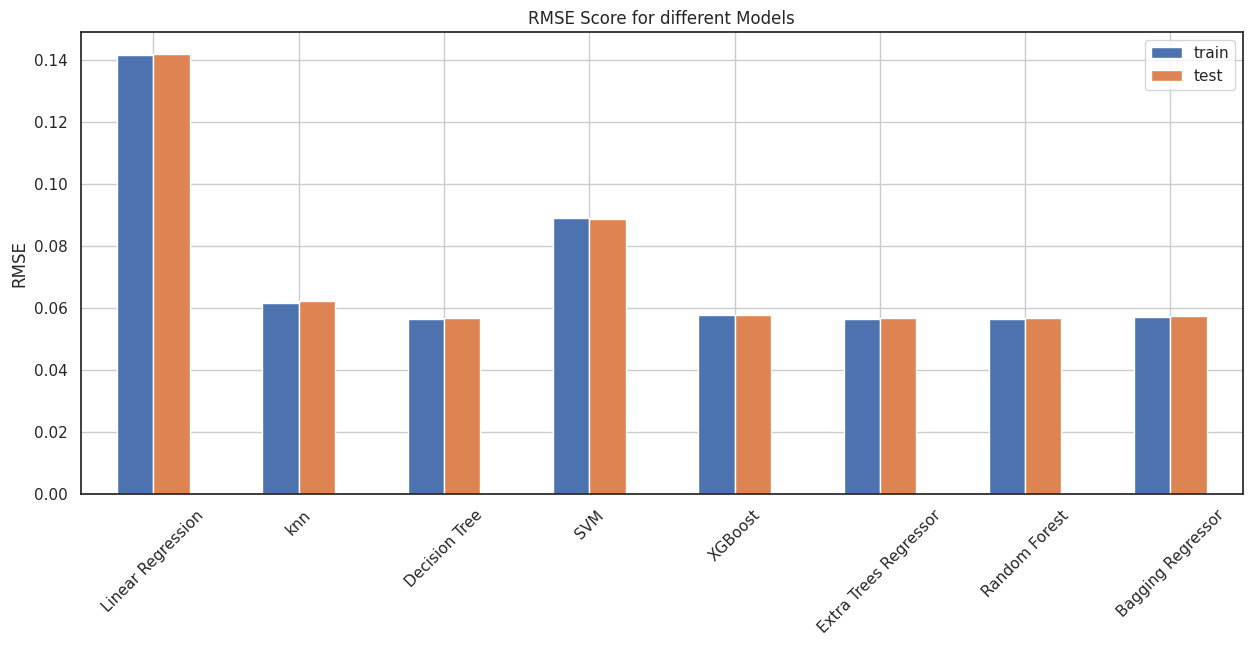

In [144]:
RMSE = evaluation_function(y_train,y_test,train_pred_df,test_pred_df,'RMSE')
RMSE.transpose().iloc[1:,:].plot(kind='bar',figsize=(15,6))
plt.ylabel('RMSE')
plt.title('RMSE Score for different Models')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [145]:
# Displaying Evaluation results(MSEs) for all the models
evaluation_function(y_train, y_test, train_pred_df, test_pred_df, 'MSE')

,Evaluation,Linear Regression,knn,Decision Tree,SVM,XGBoost,Extra Trees Regressor,Random Forest,Bagging Regressor
train,MSE,0.019987,0.003807,0.003183,0.007937,0.003343,0.003183,0.003184,0.003251
test,MSE,0.020088,0.003858,0.003228,0.007850,0.003327,0.003228,0.003225,0.003285


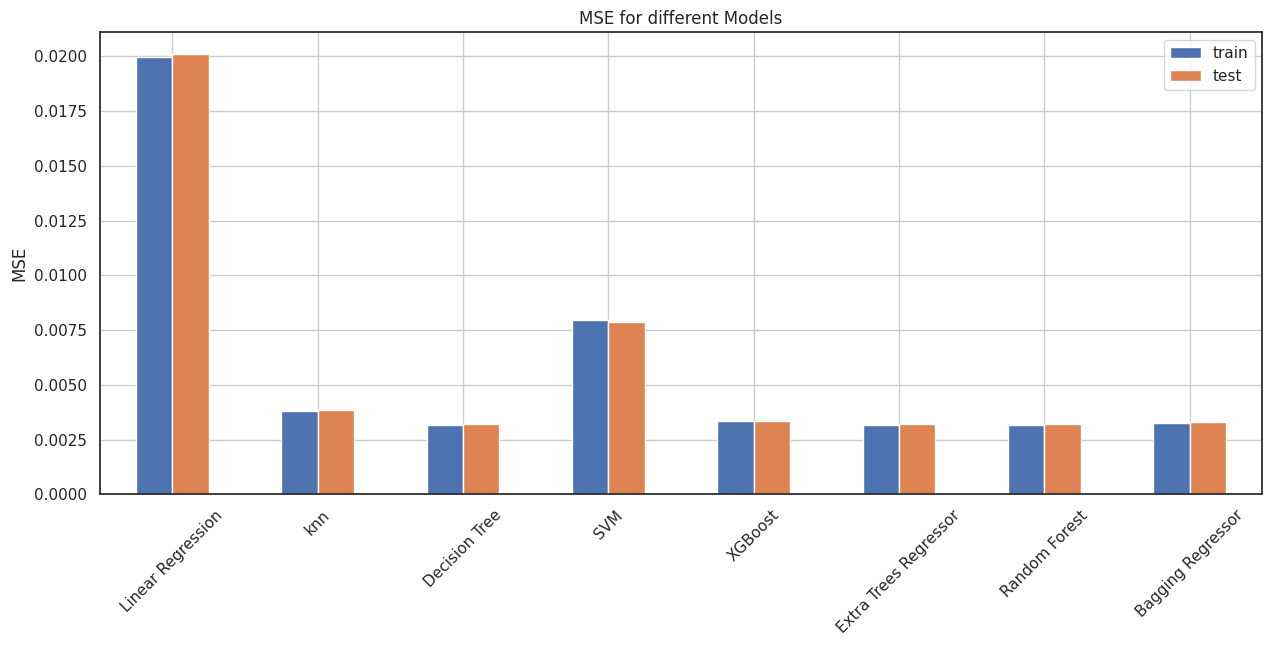

In [146]:
MSE = evaluation_function(y_train,y_test,train_pred_df,test_pred_df,'MSE')
MSE.transpose().iloc[1:,:].plot(kind='bar',figsize=(15,6))
plt.ylabel('MSE')
plt.title('MSE for different Models')
plt.xticks(rotation=45)
plt.grid()
plt.show()

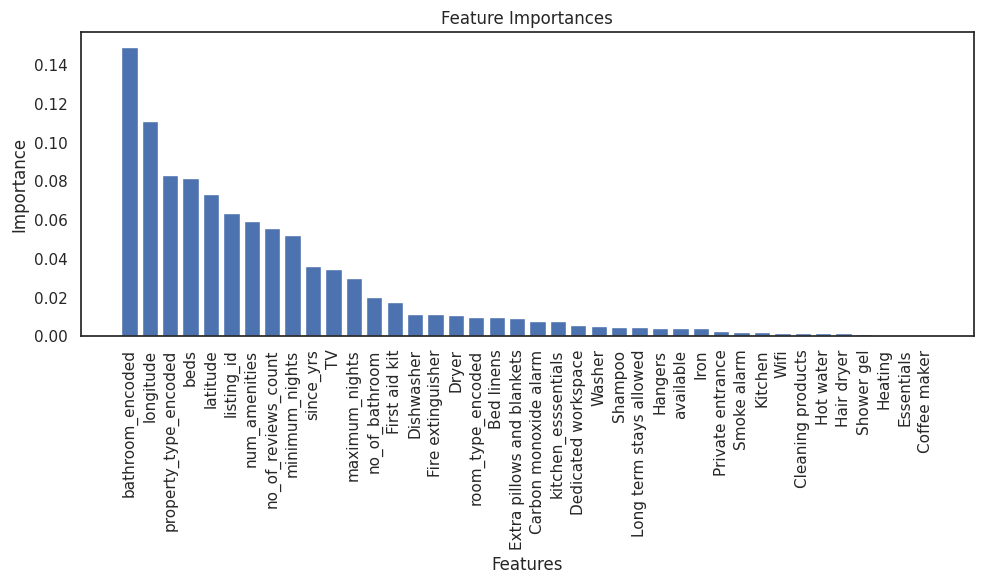

In [155]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Assuming X_train and y_train are your training features and target, respectively

# Initialize Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
dt.fit(X_train, y_train)

# Get feature importances
importances = dt.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


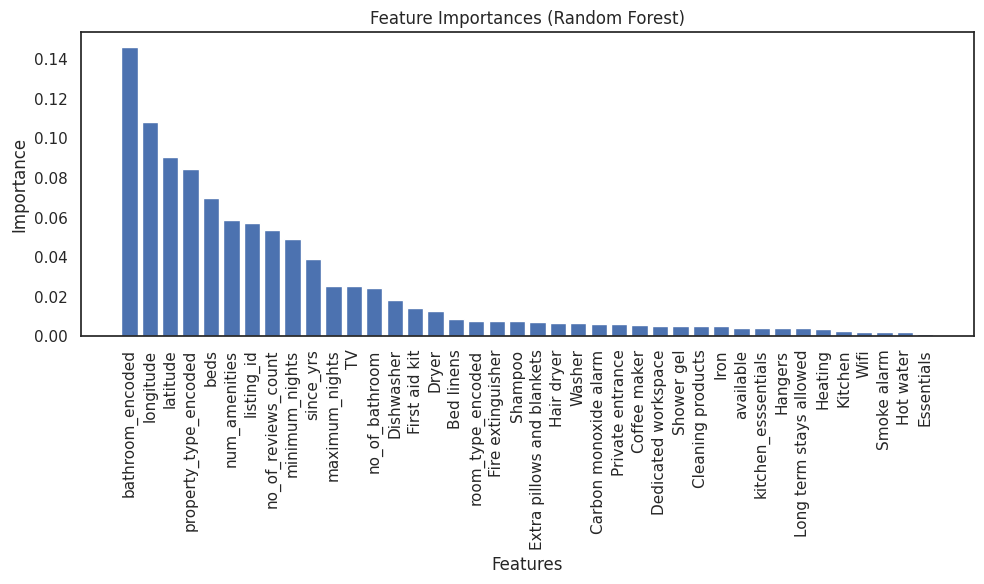

In [156]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming X_train and y_train are your training features and target, respectively

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


* remove listing_id and re- train the model.

In [165]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

# Assuming X_train and X_test are your training and testing features, respectively

# Initialize Decision Tree Regressor
dt = DecisionTreeRegressor()

# Fit the model to the training data
dt.fit(X_train, y_train)

# Get feature importances
importances = dt.feature_importances_

# Create a SelectFromModel object to select top 10 features based on importance scores
sfm = SelectFromModel(dt, threshold=-np.inf, max_features=10)  # Select top 10 features
X_train_selected = sfm.fit_transform(X_train, y_train)
X_test_selected = sfm.transform(X_test)

# Train a new Decision Tree model with selected features
dt_selected = DecisionTreeRegressor()
dt_selected.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = dt_selected.predict(X_test_selected)

# Evaluate the model (e.g., calculate MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)


# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.003318306007677136
R-squared Score: 0.8835001520781363
Root Mean Squared Error: 0.057604739454988736


In [175]:
# Get the indices of selected features
selected_feature_indices = sfm.get_support(indices=True)

# Get the names of selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print the names of selected features
print("Top 10 Selected Features:")
for feature in selected_feature_names:
    print(feature)


Top 10 Selected Features:
listing_id
minimum_nights
latitude
longitude
beds
no_of_reviews_count
num_amenities
since_yrs
property_type_encoded
bathroom_encoded


In [174]:
selected_feature_indices = sfm.get_support(indices=True)
print(selected_feature_indices)

[ 0  2  4  5  6 33 35 36 37 39]


In [168]:
type(X_train_selected)

numpy.ndarray

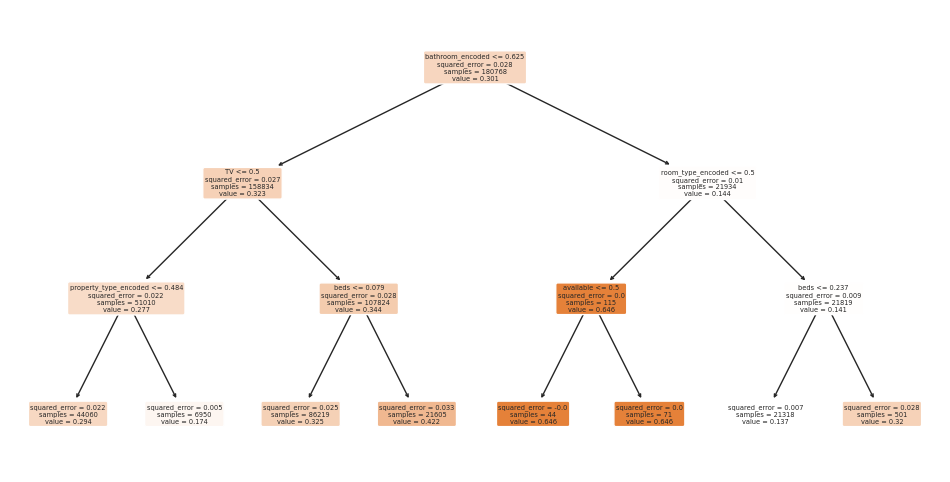

In [163]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming you have already trained your Decision Tree model and stored it in a variable named 'dt'

# Initialize Decision Tree Regressor with max_depth parameter
dt = DecisionTreeRegressor(max_depth=3)  # Adjust max_depth as needed

# Fit the model to the training data
dt.fit(X_train, y_train)

# Plot the Decision Tree
plt.figure(figsize=(12, 6))
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()
